In [1]:
import sys
sys.path.append('../..')
import argparse
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from bundlenet_continuous_variant import BunDLeNet, train_model
from functions import preprocess_data, prep_data, plotting_neuronal_behavioural, plot_latent_timeseries, timeseries_train_test_split
from plotting_functions import plot_phase_space


from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression, Lasso

import os
os.chdir('../..')

%reload_ext autoreload
%autoreload 2
os.getcwd()

2024-03-26 17:34:25.699112: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-26 17:34:25.731506: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-26 17:34:25.732173: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-26 17:34:26.265938: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


'/home/akshey/Desktop/PhD/Code_repositories/BunDLe-Net'

## Load Data

In [2]:
fish_data_id = '220119_F2_F2_run11' #220119_F2_F2_run11, 220127_F4_F4_run2
path_neuronal_data ='data/raw/fish_cilia/traces_with_vigour_directionality_behaviours/' + fish_data_id +'_cells_spike_rate_signals.npy' 
path_behaviour_data1 ='data/raw/fish_cilia/traces_with_vigour_directionality_behaviours/' + fish_data_id +'_directionality.npy'
path_behaviour_data2 ='data/raw/fish_cilia/traces_with_vigour_directionality_behaviours/' + fish_data_id +'_vigour.npy'

In [3]:
X = np.load(path_neuronal_data).T
B1 = np.load(path_behaviour_data1)
B2 = np.load(path_behaviour_data2)
B = np.c_[B1, B2]

### Remove NaNs
B = B[~np.isnan(X[:,0])]
X = X[~np.isnan(X[:,0])]
B.shape, X.shape

### Scaling
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
B = StandardScaler(with_mean=False).fit_transform(B)
X = StandardScaler(with_mean=False).fit_transform(X)

In [4]:
X_train, X_test, B_train, B_test = timeseries_train_test_split(X, B)
X_train.shape, X_test.shape, B_train.shape, B_test.shape

((3097, 1010), (516, 1010), (3097, 2), (516, 2))

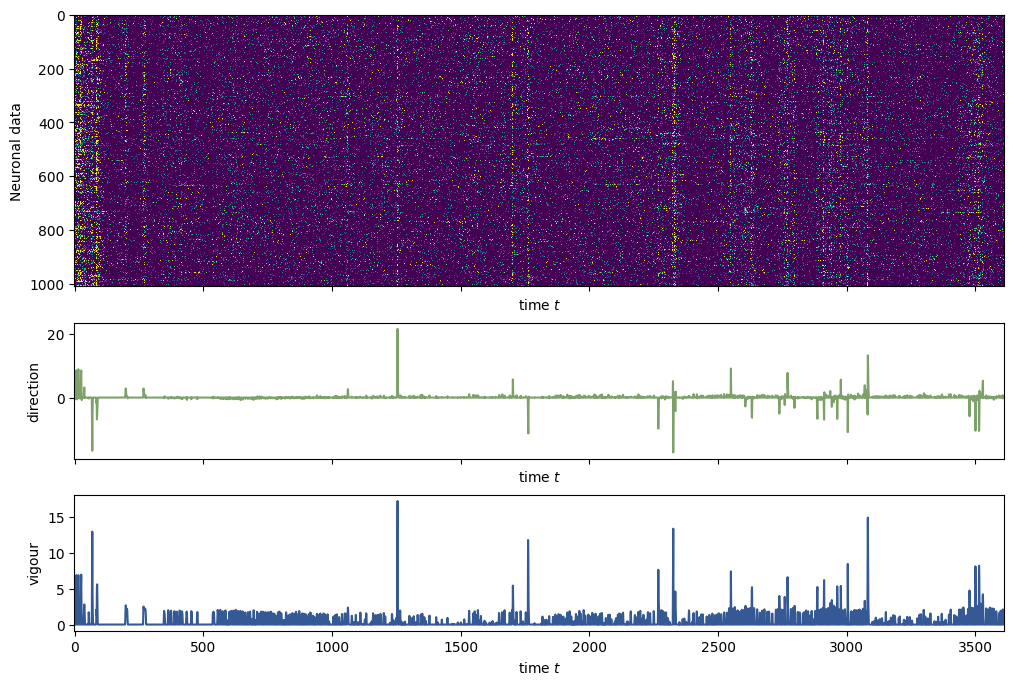

In [5]:
def plotting_neuronal_behavioural(X,B, state_names=[], **kwargs):
    fig, axs = plt.subplots(3,1,figsize=(12,8),  sharex=True, gridspec_kw={'height_ratios': [2, 1, 1]})
    im0 = axs[0].imshow(X.T,aspect='auto', interpolation='None', **kwargs)
    # tell the colorbar to tick at integers
    axs[0].set_xlabel("time $t$")
    axs[0].set_ylabel("Neuronal data")
    
    colors = ['#7EA16B', '#345995', '#AF125A']
    ylabels = ['direction', 'vigour']
    for i in range(2):
        # Behaviour 1
        im1 = axs[i+1].plot(B[:,i], c=colors[i])
        axs[i+1].set_xlabel("time $t$")
        axs[i+1].set_ylabel(ylabels[i])
        #axs[i+1].set_yticks([])

    plt.show()
    
plotting_neuronal_behavioural(X,B, vmin=0, vmax=5)

train score= 0.901434668829838
test score= 0.3233248276606858


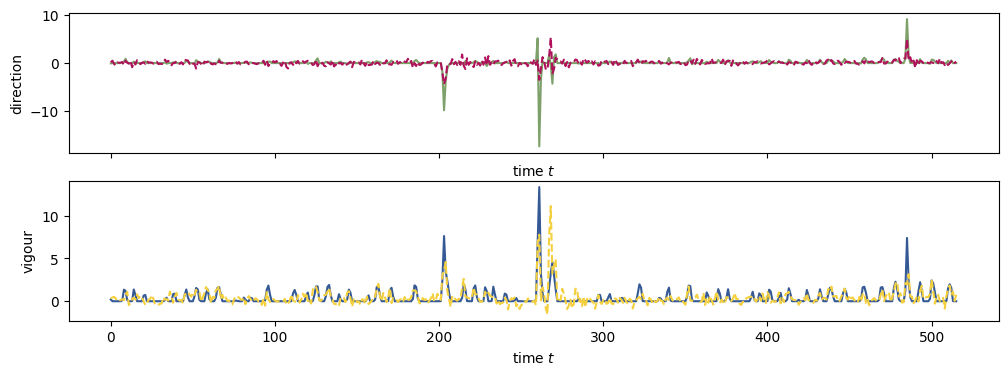

In [6]:
X.shape, B.shape
reg = LinearRegression().fit(X_train, B_train)
print('train score=',reg.score(X_train, B_train))
print('test score=',reg.score(X_test, B_test))

B_pred = reg.predict(X_test)

def plot_compare_B_pred(B,B_pred, **kwargs):
    fig, axs = plt.subplots(2,1,figsize=(12,4),  sharex=True, gridspec_kw={'height_ratios': [1, 1]})
    
    colors = ['#7EA16B', '#345995', '#AF125A', '#F4D03F']

    ylabels = ['direction', 'vigour']
    for i in range(2):
        im1 = axs[i].plot(B[:,i], c=colors[i])
        im1 = axs[i].plot(B_pred[:,i], '--', c=colors[i+2])
        axs[i].set_xlabel("time $t$")
        axs[i].set_ylabel(ylabels[i])
        
    plt.show()
    
plot_compare_B_pred(B_test, B_pred)

# Cross validation

In [114]:
from sklearn.model_selection import KFold


kf = KFold(n_splits=10)
mean_score = []

for i, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    B_train, B_test = B[train_index], B[test_index]
    # Regression
    reg = LinearRegression().fit(X_train, B_train)
    print('train score=',reg.score(X_train, B_train))
    print('test score =',reg.score(X_test, B_test))

    mean_score.append(reg.score(X_test, B_test))
    B_pred = reg.predict(X_test)
    #plot_compare_B_pred(B_test, B_pred)

print('mean score on test set: ', np.mean(mean_score))    

train score= 0.882070643252135
test score = 0.32388086792453613
train score= 0.8957978796035563
test score = -2.683391940151297
train score= 0.896286988842033
test score = -1.2218291493982236
train score= 0.8851105106932172
test score = 0.5141007090374399
train score= 0.888374926059063
test score = 0.5508745114574064
train score= 0.8955080422045694
test score = -1.486567914922127
train score= 0.8960483630498641
test score = 0.2908360537627436
train score= 0.8943359056062852
test score = 0.5528720654481605
train score= 0.8972445624814871
test score = 0.46588612405214436
train score= 0.8954548588175584
test score = 0.5609963156094258
mean score on test set:  -0.21323423571797911


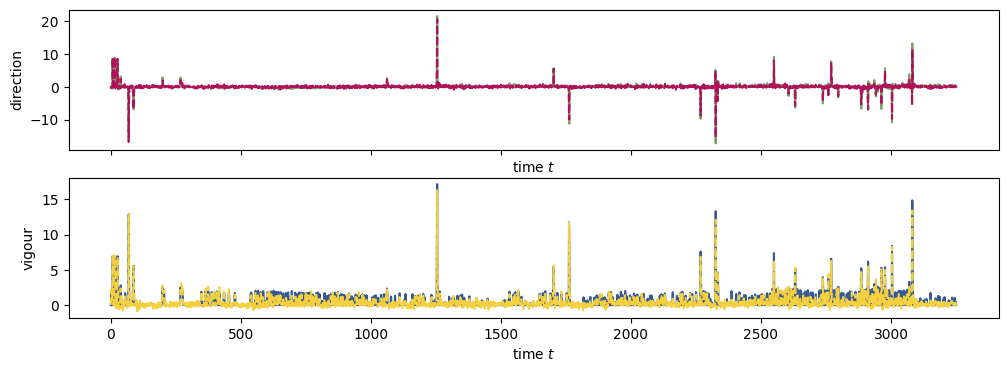

In [8]:
B_pred = reg.predict(X_train)
    
plot_compare_B_pred(B_train, B_pred)

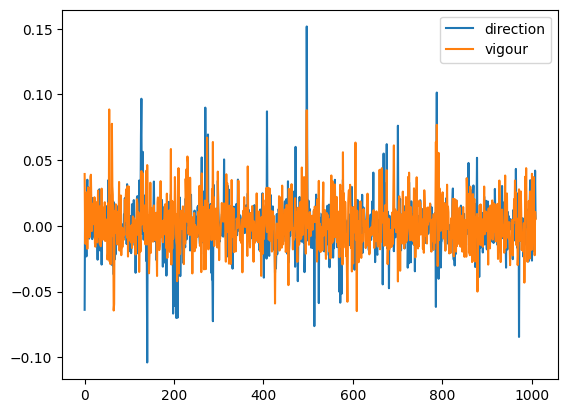

In [116]:
plt.plot(reg.coef_[0], label='direction')
plt.plot(reg.coef_[1], label='vigour')
plt.legend()
np.savetxt('coeff_linear_regression',reg.coef_)

## Lasso regression

In [124]:
kf = KFold(n_splits=10)
mean_score = []

for i, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    B_train, B_test = B[train_index], B[test_index]
    # Regression
    reg = Lasso(alpha=0.1).fit(X_train, B_train[:,:])
    print('train score=',reg.score(X_train, B_train[:,:]))
    print('test score =',reg.score(X_test, B_test[:,:]))

    mean_score.append(reg.score(X_test, B_test[:,:]))
    B_pred = reg.predict(X_test)
    #plot_compare_B_pred(B_test, B_pred)

print('mean score on test set: ', np.mean(mean_score), 'pm', np.std(mean_score))    

train score= 0.5701445062890637
test score = 0.7068356147958768
train score= 0.6242680959938725
test score = -0.3553870415491855
train score= 0.6260675524959662
test score = 0.00338981663035276
train score= 0.5852836213434727
test score = 0.374595158302051
train score= 0.6118645199622009
test score = 0.4326130903454765
train score= 0.6239649448418191
test score = -0.052224828415332936
train score= 0.6275465768192267
test score = 0.3887294387319336
train score= 0.606800466857812
test score = 0.5507802218512705
train score= 0.6234515123363663
test score = 0.387490394864875
train score= 0.6137766239966673
test score = 0.5127702269556926
mean score on test set:  0.29495920925130104 pm 0.3088160079446867


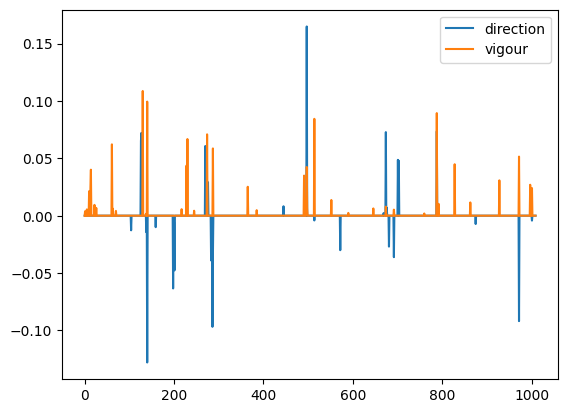

In [125]:
plt.plot(reg.coef_[0], label='direction')
plt.plot(reg.coef_[1], label='vigour')
plt.legend()
np.savetxt('coeff_lasso_reg_alpha_1E-1',reg.coef_)

# Taking many time steps into account


In [126]:
X_, B_ = prep_data(X, B, win = 10)
X_ = X_[:,1,:,:].reshape(X_.shape[0], -1)

kf = KFold(n_splits=10)
mean_score = []

for i, (train_index, test_index) in enumerate(kf.split(X_)):
    X_train, X_test = X_[train_index], X_[test_index]
    B_train, B_test = B_[train_index], B_[test_index]
    # Regression
    reg = Lasso(alpha=0.1).fit(X_train, B_train[:,:])
    print('train score=',reg.score(X_train, B_train[:,:]))
    print('test score =',reg.score(X_test, B_test[:,:]))

    mean_score.append(reg.score(X_test, B_test[:,:]))
    B_pred = reg.predict(X_test)
    #plot_compare_B_pred(B_test, B_pred)

print('mean score on test set: ', np.mean(mean_score), 'pm', np.std(mean_score))    

train score= 0.6457176868451706
test score = 0.7129780926150533
train score= 0.6972563125370765
test score = -0.3161579912901665
train score= 0.6984805347796641
test score = 0.09033731876487594
train score= 0.6424572600722083
test score = 0.45035955225623575
train score= 0.6723013405980238
test score = 0.5233434209888361
train score= 0.697284460145096
test score = 0.0392925032691161
train score= 0.692959032499325
test score = 0.32646508251253964
train score= 0.6854003362456175
test score = 0.5494643753110338
train score= 0.680743650142879
test score = 0.46397098470860376
train score= 0.6935670743336428
test score = 0.5165632133504984
mean score on test set:  0.3356616552486626 pm 0.2930222074199762


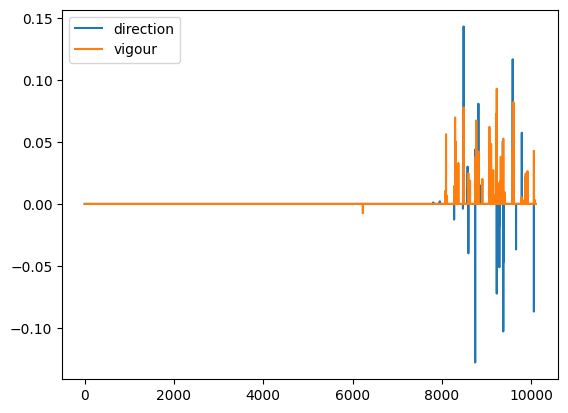

In [127]:
plt.plot(reg.coef_[0], label='direction')
plt.plot(reg.coef_[1], label='vigour')
plt.legend()
np.savetxt('coeff_lasso_reg_alpha_1E-1_win_10',reg.coef_)

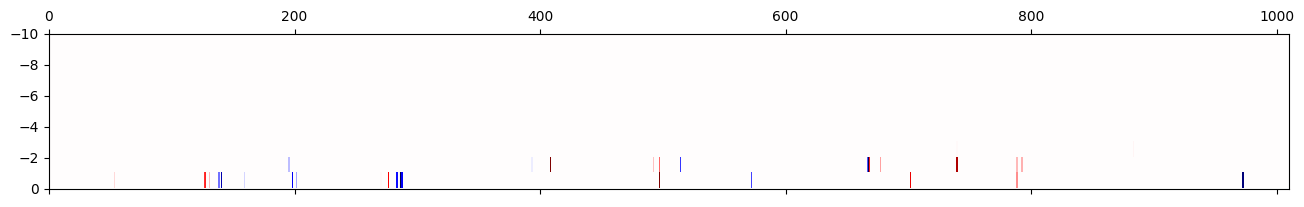

<Figure size 640x480 with 0 Axes>

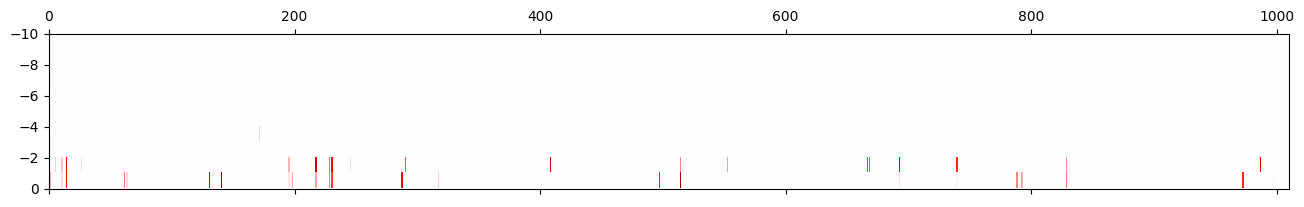

In [110]:
plt.matshow(reg.coef_[0].reshape(10,-1), aspect='auto', cmap='seismic', vmin=-0.1, vmax=0.1, extent=[0,X.shape[1],0, -10])
plt.figure()
plt.matshow(reg.coef_[1].reshape(10,-1), aspect='auto', cmap='seismic', vmin=-0.1, vmax=0.1, extent=[0,X.shape[1],0, -10])


In [128]:
np.savetxt('coeffs_lasso_reg_alpha_1E-1_win_10_direction', reg.coef_[0].reshape(10,-1))
np.savetxt('coeffs_lasso_reg_alpha_1E-1_win_10_vigour', reg.coef_[1].reshape(10,-1))
